In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Loading data train for exploration
data_train = pd.read_csv('data/train.csv')

## Data Exploration

In [3]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Splitting columns into numerical and categorical
categorical_cols = list(data_train.select_dtypes(exclude=['number','bool_']).columns)
numerical_cols = [c for c in data_train.columns if c not in categorical_cols]
numerical_cols.remove('PassengerId')

print('Categorical Variables: {}'.format(categorical_cols))
print('Numerical Variables: {}'.format(numerical_cols))

Categorical Variables: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Numerical Variables: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


### Exploring numerical data

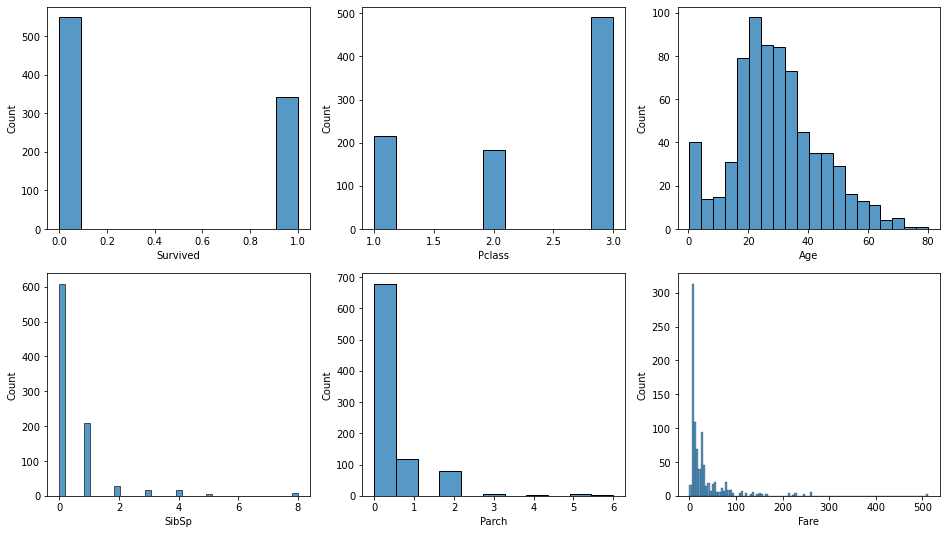

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
axs = axs.flatten()

for col, ax in zip(numerical_cols, axs):
    sns.histplot(data_train, x=col, ax=ax)

- Fare needs to be normalized
- Pclass has to be encoded

<AxesSubplot:>

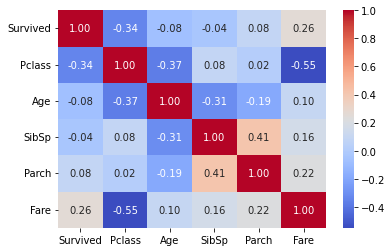

In [8]:
# Correlations
sns.heatmap(
    data_train[numerical_cols].corr(),
    annot = True,
    fmt = '.2f',
    cmap = 'coolwarm'
)

- Negative corr between Pclass and Fare
- Positive corr between Parch and SibSp

### Exploring categorical variables

In [9]:
print(categorical_cols)

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


**1. Cabin**

In [10]:
# 1. Cabin
data_train['Cabin'].head(100)

0         NaN
1         C85
2         NaN
3        C123
4         NaN
       ...   
95        NaN
96         A5
97    D10 D12
98        NaN
99        NaN
Name: Cabin, Length: 100, dtype: object

- Attempt to extract relevant info from Cabin
    - Have a look at first letter (cabin group)
    - Have a look at number of Cabins

In [11]:
# Cabin Group
def get_cabin_group(cabin):
    if isinstance(cabin, str):
        cabin_split = cabin.split()
        return cabin_split[0][0]        
    else:
        return 'none'

In [12]:
data_train['CabinGroup'] = data_train['Cabin'].map(get_cabin_group)

Text(0.5, 1.0, 'Survival Probability by SibSp')

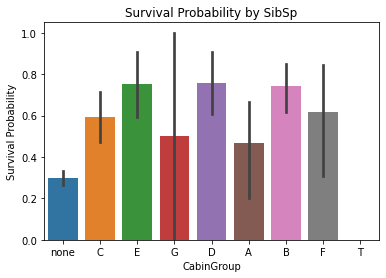

In [13]:
sns.barplot(x='CabinGroup', y='Survived', data=data_train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by SibSp')

In [14]:
# Cabin Number
def get_cabin_number(cabin):
    if isinstance(cabin, str):
        cabin_split = cabin.split()
        return len(cabin_split)        
    else:
        return 'none'

In [15]:
data_train['CabinNumber'] = data_train['Cabin'].map(get_cabin_number)

Text(0.5, 1.0, 'Survival Probability by SibSp')

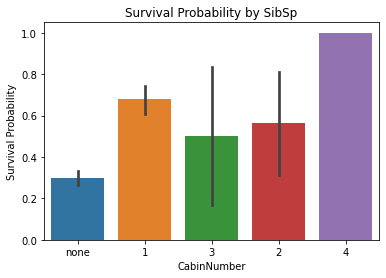

In [16]:
sns.barplot(x='CabinNumber', y='Survived', data=data_train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by SibSp')

In [17]:
# Has Cabin
def get_has_cabin(cabin):
    if isinstance(cabin, str):
        return 1        
    else:
        return 0

In [18]:
data_train['HasCabin'] = data_train['Cabin'].map(get_has_cabin)

Text(0.5, 1.0, 'Survival Probability by SibSp')

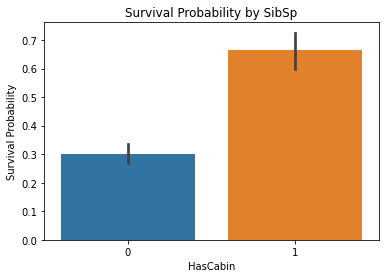

In [19]:
sns.barplot(x='HasCabin', y='Survived', data=data_train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by SibSp')

- Has Cabin seems to be only variable worth keeping

**2. Ticket**

In [20]:
data_train['Ticket'].head(20)

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
15              248706
16              382652
17              244373
18              345763
19                2649
Name: Ticket, dtype: object

- Number vs (Number + Pattern)

In [21]:
def get_is_number(ticket):
    try:
        float(ticket)
        return 1
    except:
        return 0

In [22]:
data_train['IsTicketNumber'] = data_train['Ticket'].map(get_is_number)

Text(0.5, 1.0, 'Survival Probability by IsTicketNumber')

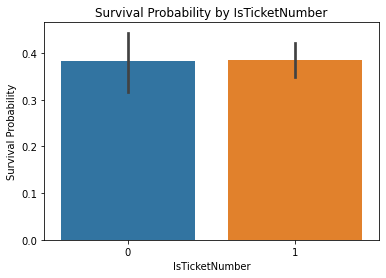

In [23]:
sns.barplot(x='IsTicketNumber', y='Survived', data=data_train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by IsTicketNumber')

- No correlation whatsoever

**3. Name**

In [24]:
# Extract title
title_dict = {
    'Mr.': 'Mr',
    'Mrs.': 'Mrs',
    'Ms.': 'Ms',
    'Master.': 'Ms',
    'Miss.': 'Miss',
    'Dr.': 'Dr',
    'Rev.': 'Rev'
}

def get_title_from_name(name):
    name_split = name.split()
    for n in name_split:
        if n[-1] != '.':
            continue

        if n in title_dict.keys():
            return title_dict[n]
        else:
            return 'other'

    return None

In [25]:
data_train['NameTitle'] = data_train['Name'].map(get_title_from_name)

In [26]:
data_train['NameTitle'].value_counts()

Mr       517
Miss     182
Mrs      125
Ms        41
other     13
Dr         7
Rev        6
Name: NameTitle, dtype: int64

Text(0.5, 1.0, 'Survival Probability by NameTitle')

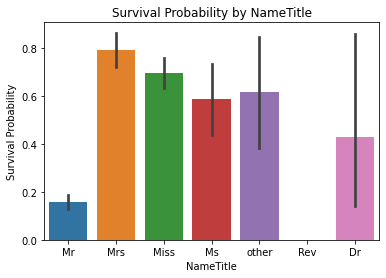

In [27]:
sns.barplot(x='NameTitle', y='Survived', data=data_train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by NameTitle')

- There are significant differences in survival rates between NameTitles 

**4. Sex**

In [28]:
data_train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

Text(0.5, 1.0, 'Survival Probability by Sex')

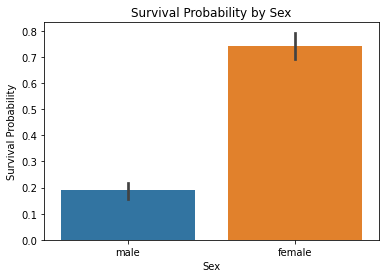

In [29]:
sns.barplot(x='Sex', y='Survived', data=data_train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Sex')

**5. Embarked**

In [30]:
data_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Text(0.5, 1.0, 'Survival Probability by Embarked')

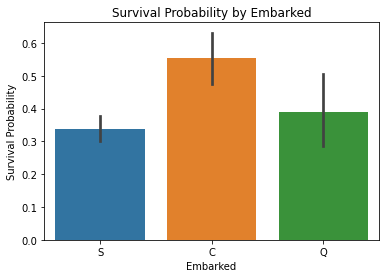

In [31]:
sns.barplot(x='Embarked', y='Survived', data=data_train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Embarked')

## Feature Engineering and Data Processing

In [32]:
def process_data(data):
    df_out = pd.DataFrame()

    # Copying PassengerId
    df_out['PassengerId'] = data['PassengerId']
    
    # Copying Survived (if existing)
    if 'Survived' in data.columns:
        df_out['Survived'] = data['Survived']
    
    ## Numerical data
    # Pclass - one-hot encoding
    df_Pclass = pd.get_dummies(
        data['Pclass'],
        drop_first=False
    )
    df_out['IsFirstClass'] = df_Pclass[1]
    df_out['IsSecondClass'] = df_Pclass[2]

    # Age
    df_out['Age'] = data['Age']
    df_out['Age'].fillna(df_out['Age'].mean(), inplace=True)
    
    # SibSp
    df_out['SibSp'] = data['SibSp']
    df_out['SibSp'].fillna(df_out['SibSp'].mean(), inplace=True)
    
    # Parch
    df_out['Parch'] = data['Parch']
    df_out['Parch'].fillna(df_out['Parch'].mean(), inplace=True)
    
    # Fare
    df_out['NormFare'] = np.log(data['Fare'] + 1)
    df_out['NormFare'].fillna(df_out['NormFare'].mean(), inplace=True)
    
    # Categorical data
    # Name
    df_NameTitle = data['Name'].map(get_title_from_name)
    df_NameTitleDummies = pd.get_dummies(
        df_NameTitle,
        prefix='IsTitle',
        prefix_sep='',
        drop_first=True
    )
    for var in df_NameTitleDummies.columns:
        df_out[var] = df_NameTitleDummies[var]
    
    # Cabin
    df_out['HasCabin'] = data['Cabin'].map(get_has_cabin)

    # Sex
    df_SexDummies = pd.get_dummies(
        data['Sex'],
        prefix='Is',
        prefix_sep='_',
        drop_first=True
    )
    for var in df_SexDummies.columns:
        df_out[var] = df_SexDummies[var]
    
    # Embarked
    df_EmbarkedDummies = pd.get_dummies(
        data['Embarked'],
        prefix='Embarked',
        prefix_sep='',
        drop_first=True
    )
    for var in df_EmbarkedDummies.columns:
        df_out[var] = df_EmbarkedDummies[var]
    
    return df_out

In [33]:
raw_data_train = pd.read_csv('data/train.csv')
raw_data_test = pd.read_csv('data/test.csv')

In [34]:
processed_data_train = process_data(raw_data_train)
processed_data_test = process_data(raw_data_test)

In [35]:
processed_data_train.head()

,PassengerId,Survived,IsFirstClass,IsSecondClass,Age,SibSp,Parch,NormFare,IsTitleMiss,IsTitleMr,IsTitleMrs,IsTitleMs,IsTitleRev,IsTitleother,HasCabin,Is_male,EmbarkedQ,EmbarkedS
0,1,0,0,0,22.0,1,0,2.110213,0,1,0,0,0,0,0,1,0,1
1,2,1,1,0,38.0,1,0,4.280593,0,0,1,0,0,0,1,0,0,0
2,3,1,0,0,26.0,0,0,2.188856,1,0,0,0,0,0,0,0,0,1
3,4,1,1,0,35.0,1,0,3.990834,0,0,1,0,0,0,1,0,0,1
4,5,0,0,0,35.0,0,0,2.202765,0,1,0,0,0,0,0,1,0,1


In [36]:
processed_data_test.head()

,PassengerId,IsFirstClass,IsSecondClass,Age,SibSp,Parch,NormFare,IsTitleMiss,IsTitleMr,IsTitleMrs,IsTitleMs,IsTitleRev,IsTitleother,HasCabin,Is_male,EmbarkedQ,EmbarkedS
0,892,0,0,34.5,0,0,2.178064,0,1,0,0,0,0,0,1,1,0
1,893,0,0,47.0,1,0,2.079442,0,0,1,0,0,0,0,0,0,1
2,894,0,1,62.0,0,0,2.369075,0,1,0,0,0,0,0,1,1,0
3,895,0,0,27.0,0,0,2.268252,0,1,0,0,0,0,0,1,0,1
4,896,0,0,22.0,1,1,2.586824,0,0,1,0,0,0,0,0,0,1


In [37]:
processed_data_test.isna().sum()

PassengerId      0
IsFirstClass     0
IsSecondClass    0
Age              0
SibSp            0
Parch            0
NormFare         0
IsTitleMiss      0
IsTitleMr        0
IsTitleMrs       0
IsTitleMs        0
IsTitleRev       0
IsTitleother     0
HasCabin         0
Is_male          0
EmbarkedQ        0
EmbarkedS        0
dtype: int64

### Correlation Matrix

[Text(0.5, 0, 'PassengerId'),
 Text(1.5, 0, 'Survived'),
 Text(2.5, 0, 'IsFirstClass'),
 Text(3.5, 0, 'IsSecondClass'),
 Text(4.5, 0, 'Age'),
 Text(5.5, 0, 'SibSp'),
 Text(6.5, 0, 'Parch'),
 Text(7.5, 0, 'NormFare'),
 Text(8.5, 0, 'IsTitleMiss'),
 Text(9.5, 0, 'IsTitleMr'),
 Text(10.5, 0, 'IsTitleMrs'),
 Text(11.5, 0, 'IsTitleMs'),
 Text(12.5, 0, 'IsTitleRev'),
 Text(13.5, 0, 'IsTitleother'),
 Text(14.5, 0, 'HasCabin'),
 Text(15.5, 0, 'Is_male'),
 Text(16.5, 0, 'EmbarkedQ'),
 Text(17.5, 0, 'EmbarkedS')]

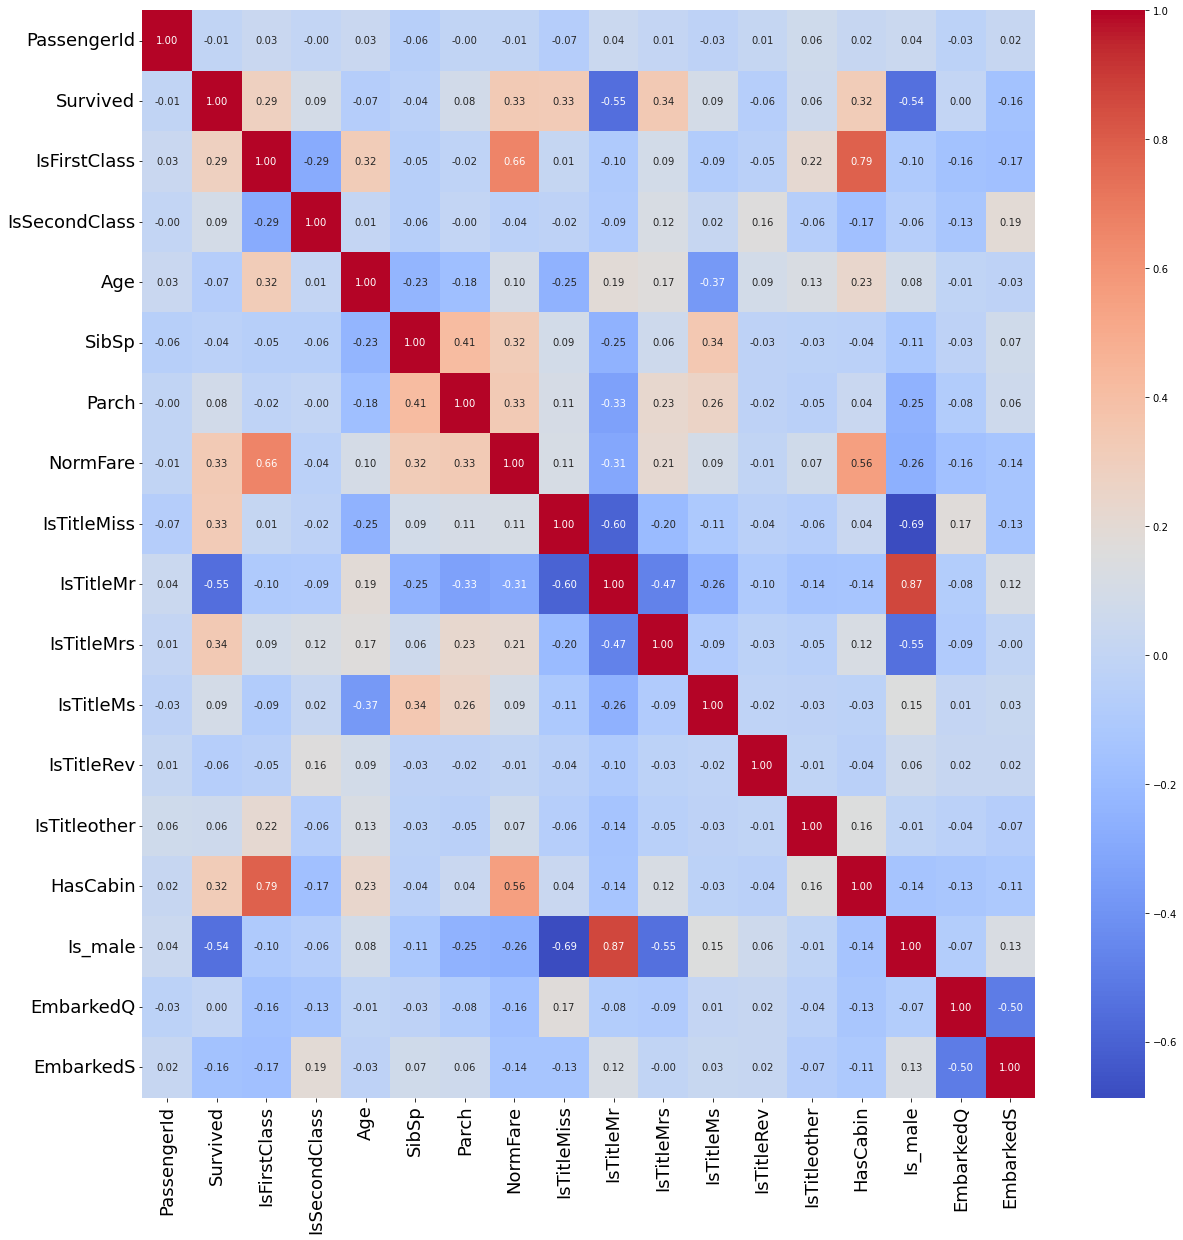

In [38]:
# Correlations
fig = plt.figure(figsize=(20, 20))
res = sns.heatmap(
    processed_data_train.corr(),
    annot = True,
    fmt = '.2f',
    cmap = 'coolwarm'
)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 18)

# Model Building

In [39]:
X = processed_data_train.drop(columns=['PassengerId', 'Survived'])
y = processed_data_train['Survived']

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=1
)

In [42]:
sc = StandardScaler().fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [43]:
from sklearn.linear_model import LogisticRegression

In [46]:
clf = LogisticRegression(random_state=1, C=10).fit(X_train_std, y_train)

In [47]:
final_score = clf.score(X_test_std, y_test)
print('Score: {}'.format(final_score))

Score: 0.7947761194029851
